# Get metrics: heatwave, polluted day and wildfire

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()


<Figure size 800x600 with 0 Axes>

In [4]:
df = pd.read_parquet("outputs/final_merge_5_western_us.parquet")

In [5]:
df = df.reset_index()

## Dates

In [6]:
df.time.min()

Timestamp('2006-01-01 00:00:00')

In [7]:
df.time.max() 

Timestamp('2020-12-31 00:00:00')

In [8]:
df = df.rename(columns={'location_label': 'GEOID'})

# Preprocessing

# Heat day - temp over 95th perc of summer months in the first 5 years as treshold

In [9]:
def get_tmax95_summer_first_5_years(x):
    # Filter the data for summer months 
    summer = x[x["time"].dt.month.isin([6, 7, 8, 9])]
    
    # Restrict to the first 5 years
    summer_first_5_years = summer[summer["time"].dt.year <= summer["time"].dt.year.min() + 4]
    
    # Calculate the 95th percentile
    return summer_first_5_years['tmax'].quantile(0.95)
    
tmax95_series = df.groupby('GEOID').apply(get_tmax95_summer_first_5_years)

df['tmax95'] = df['GEOID'].map(tmax95_series)

In [10]:
extreme_day_threshold = 32.22 # in C

In [16]:
df['heatday'] = np.where(
    (df['tmax'] >= df['tmax95']) & (df['tmax']>= extreme_day_threshold), 
    True, 
    False)

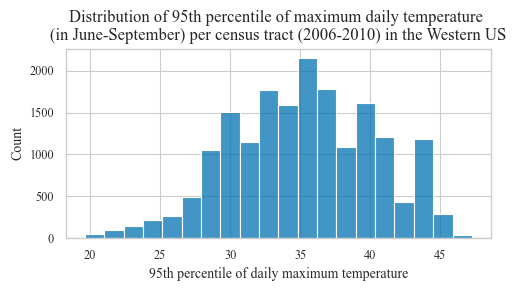

In [22]:
plt.rcParams["font.family"] = "Times New Roman"
axs = plt.subplots(figsize=(5.1, 3))
axs = sns.histplot(tmax95_series, bins=20)
axs.set_xlabel("95th percentile of daily maximum temperature", fontsize=10)
axs.set_ylabel("Count", fontsize=10)
axs.set_title("Distribution of 95th percentile of maximum daily temperature \n(in June-September) per census tract (2006-2010) in the Western US", fontsize=12)
plt.tight_layout()
plt.savefig("figures/95th_percentile_distribution.png", dpi=300)

In [27]:
dfc[dfc < extreme_day_threshold].count()

5164

## Wildfire day

In [30]:
df['wfday'].value_counts() # western us

wfday
0.0    99098100
1.0      115632
Name: count, dtype: int64

In [31]:
df['wfday'] = np.where(df['wfday'] == 1.0, True, False)

In [32]:
df['wfday'].value_counts()

wfday
False    99098100
True       115632
Name: count, dtype: int64

In [33]:
df = df.drop(columns=["tmax95"]) #, "tmin05"])

## Smoke Polluted Day

In [34]:
df['smoke_pm_non_zero'] = np.where(df['smoke_pm'] > 0.0, True, False)

In [35]:
# As seen in https://www.researchsquare.com/article/rs-2866201/v1

df['smoke_pm_gt_five'] = np.where(df['smoke_pm'] > 5.0, True, False)

In [36]:
df.head()

,time,GEOID,wfday,tmax,smoke_pm,heatday,smoke_pm_non_zero,smoke_pm_gt_five
0,2006-01-01,04001942600,False,15.978498,0.0,False,False,False
1,2006-01-01,04001942700,False,14.836937,0.0,False,False,False
2,2006-01-01,04001944000,False,14.192923,0.0,False,False,False
3,2006-01-01,04001944100,False,14.254541,0.0,False,False,False
4,2006-01-01,04001944201,False,15.200634,0.0,False,False,False


In [37]:
df.to_parquet("outputs/d1-heat-wf-smokeday-230929.parquet")